# Defect Classifier


In [ ]:
import os
import numpy as np
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


In [11]:
# Config
DATASET_PATH = Path('/Users/willekjellberg/.cache/kagglehub/datasets/zhangyunsheng/defects-class-and-location/versions/1/images/images')
CLASSES = ['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot']
IMG_SIZE = 128

def load_image(path):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    # Crop black borders
    mask = img > 10
    if mask.any():
        rows, cols = np.where(mask)
        img = img[rows.min():rows.max()+1, cols.min():cols.max()+1]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # CLAHE + z-score + min-max to [0,1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = img.astype(np.float32)
    mean, std = np.mean(img), np.std(img)
    if std > 0:
        img = (img - mean) / std
    mn, mx = img.min(), img.max()
    if mx > mn:
        img = (img - mn) / (mx - mn)
    return img[..., np.newaxis]


In [12]:
# Load data
X, y = [], []
for i, cls in enumerate(CLASSES):
    for path in (DATASET_PATH / cls).glob('*.jpg'):
        img = load_image(path)
        if img is not None:
            X.append(img)
            y.append(i)

X, y = np.array(X), np.array(y)
print(f"Loaded {len(X)} images, {len(CLASSES)} classes")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Class weights for imbalanced data
class_counts = np.bincount(y_train)
class_weights = {i: len(y_train) / (len(CLASSES) * c) for i, c in enumerate(class_counts)}


Loaded 1598 images, 7 classes


In [ ]:
# Model
model = tf.keras.Sequential([
    layers.Input((IMG_SIZE, IMG_SIZE, 1)),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.15),
    
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(32).prefetch(2)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(2)

history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=int(os.getenv("EPOCHS", "30")),
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping('val_accuracy', patience=15, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', factor=0.5, patience=5)
    ]
)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.2598 - loss: 1.8917 - val_accuracy: 0.1375 - val_loss: 2.0241 - learning_rate: 0.0010
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.2864 - loss: 1.7824 - val_accuracy: 0.0188 - val_loss: 3.2953 - learning_rate: 0.0010
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.3232 - loss: 1.7004 - val_accuracy: 0.1500 - val_loss: 2.6376 - learning_rate: 0.0010
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.3059 - loss: 1.7399 - val_accuracy: 0.1375 - val_loss: 3.0978 - learning_rate: 0.0010
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.3130 - loss: 1.7544 - val_accuracy: 0.1375 - val_loss: 3.7866 - learning_rate: 0.0010
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.3498 - loss: 1.6621 - val_accuracy: 0.1375 - val_loss: 4.3083 - learning_rate: 0.0010
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.3365 - loss: 1.6599 - val_a

Test Accuracy: 30.94%


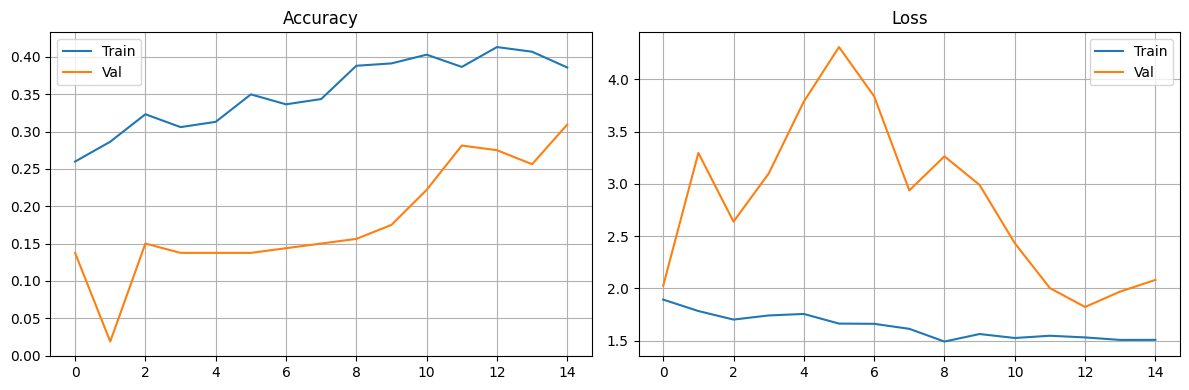

In [ ]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.1%}")


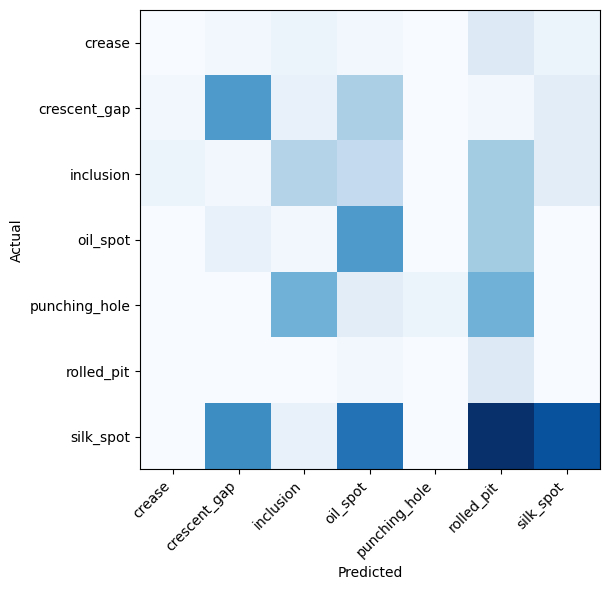

               precision    recall  f1-score   support

       crease       0.00      0.00      0.00        11
 crescent_gap       0.43      0.51      0.47        45
    inclusion       0.30      0.28      0.29        43
     oil_spot       0.28      0.56      0.38        41
punching_hole       1.00      0.05      0.09        44
   rolled_pit       0.05      0.83      0.10         6
    silk_spot       0.77      0.26      0.39       130

     accuracy                           0.31       320
    macro avg       0.41      0.36      0.24       320
 weighted avg       0.59      0.31      0.33       320



In [ ]:
# Save
model.save('defect_classifier_model.keras')
